<a href="https://colab.research.google.com/github/gankidisaicharan/Breast-Cancer-detection/blob/main/BreastCancer(upgraded).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
import pathlib
import numpy as np
import random
import matplotlib.pyplot as plt
import os
import pandas as pd
import tensorflow as tf
import warnings
warnings.filterwarnings('ignore')

In [ ]:
from os import listdir
from keras.preprocessing.image import ImageDataGenerator
import cv2
import matplotlib.pyplot as plt
%matplotlib inline
import imutils
from tensorflow.keras.models import Model,load_model
from tensorflow.keras.layers import Conv2D,Input,ZeroPadding2D,BatchNormalization,Flatten,Activation,Dense,MaxPooling2D
from sklearn.model_selection import train_test_split
from sklearn.utils import shuffle #shuffling the data improves the model

In [ ]:
image_dir='/content/drive/MyDrive/PROJECTS/breast cancer detection/Dataset_BUSI_with_GT'

In [ ]:
augmentedimages='/content/drive/MyDrive/PROJECTS/breast cancer detection/augmented-images'

In [ ]:
if not os.path.exists(augmentedimages):
    os.makedirs(augmentedimages)
    os.makedirs('/content/drive/MyDrive/PROJECTS/breast cancer detection/augmented-images/normal')
    os.makedirs('/content/drive/MyDrive/PROJECTS/breast cancer detection/augmented-images/maligant')
    os.makedirs('/content/drive/MyDrive/PROJECTS/breast cancer detection/augmented-images/benign')

In [ ]:
def augment_data(file_dir, n_generated_samples, save_to_dir):
    data_gen = ImageDataGenerator(rotation_range=10,
                                  width_shift_range=0.1,
                                  height_shift_range=0.1,
                                  shear_range=0.1,
                                  brightness_range=(0.3, 1.0),
                                  horizontal_flip=True,
                                  vertical_flip=True,
                                  fill_mode='nearest'
                                 )

    for filename in listdir(file_dir):
        image = cv2.imread(file_dir + '/' + filename)
        # reshape the image
        image = image.reshape((1,)+image.shape)
        save_prefix = 'aug_' + filename[:-4]
        i=0
        for batch in data_gen.flow(x=image, batch_size=1, save_to_dir=save_to_dir,save_prefix=save_prefix, save_format='png'):
                i += 1
                if i > n_generated_samples:
                    break

In [ ]:
augmented_data_path='/content/drive/MyDrive/PROJECTS/breast cancer detection/augmented-images'
augment_data(file_dir=image_dir+'/'+'normal',n_generated_samples=6, save_to_dir=augmented_data_path+'/'+'normal')


In [ ]:
augment_data(file_dir=image_dir+'/'+'malignant', n_generated_samples=9, save_to_dir=augmented_data_path+'/'+'maligant')

In [ ]:
augment_data(file_dir=image_dir+'/'+'benign', n_generated_samples=9, save_to_dir=augmented_data_path+'/'+'benign')

In [ ]:
file_path = '/content/drive/MyDrive/PROJECTS/breast cancer detection/augmented-images'
data_dir = pathlib.Path(file_path)
class_names = np.array(sorted([item.name for item in data_dir.glob('*')]))
print(class_names)

['benign' 'maligant' 'normal']


In [ ]:
import cv2
import imutils
import matplotlib.pyplot as plt

def crop_image_contour(image, plot=False):
    if image is None:
        print("Invalid image")
        return None

    # Convert the image to grayscale, and blur it slightly
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    gray = cv2.GaussianBlur(gray, (5, 5), 0)

    thresh = cv2.threshold(gray, 45, 255, cv2.THRESH_BINARY)[1]
    thresh = cv2.erode(thresh, None, iterations=2)
    thresh = cv2.dilate(thresh, None, iterations=2)

    # Find contours in thresholded image, then grab the largest one
    cnts = cv2.findContours(thresh.copy(), cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    cnts = imutils.grab_contours(cnts)

    if len(cnts) == 0:
        print("No contours found in the image")
        return None

    c = max(cnts, key=cv2.contourArea)
    # extreme points
    extLeft = tuple(c[c[:, :, 0].argmin()][0])
    extRight = tuple(c[c[:, :, 0].argmax()][0])
    extTop = tuple(c[c[:, :, 1].argmin()][0])
    extBot = tuple(c[c[:, :, 1].argmax()][0])

    # crop new image out of the original image using the four extreme points (left, right, top, bottom)
    new_image = image[extTop[1]:extBot[1], extLeft[0]:extRight[0]]

    if plot:
        plt.figure()
        plt.subplot(1, 2, 1)
        plt.imshow(image)
        plt.tick_params(axis='both', which='both', top=False, bottom=False, left=False, right=False,labelbottom=False, labeltop=False, labelleft=False, labelright=False)
        plt.title('Original Image')
        plt.subplot(1, 2, 2)
        plt.imshow(new_image)
        plt.tick_params(axis='both', which='both',top=False, bottom=False, left=False, right=False,labelbottom=False, labeltop=False, labelleft=False, labelright=False)
        plt.title('Cropped Image')
        plt.show()

    return new_image


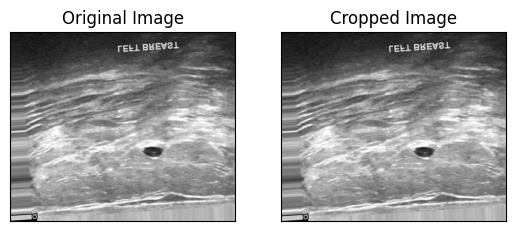

In [ ]:
ex_img = cv2.imread('/content/drive/MyDrive/PROJECTS/breast cancer detection/augmented-images/benign/aug_benign (1)_0_2622.png')
ex_crop_img = crop_image_contour(ex_img, True)

In [ ]:
# Path to the data directory
data_dir = '/content/drive/MyDrive/PROJECTS/breast cancer detection/augmented-images'
SEED = 1   # maybe can do with random seed generator and compare results with different seed values in the future.
BATCH_SIZE = 32
IMG_SIZE = (224,224)

X_train = tf.keras.preprocessing.image_dataset_from_directory(
    data_dir,
    seed = SEED,
    image_size = IMG_SIZE,
    batch_size = BATCH_SIZE,
    validation_split = 0.2,
    subset = 'training'
)

X_validation = tf.keras.preprocessing.image_dataset_from_directory(
    data_dir,
    seed = SEED,
    image_size = IMG_SIZE,
    batch_size = BATCH_SIZE,
    validation_split = 0.2,
    subset = 'validation'
)

Found 12438 files belonging to 3 classes.
Using 9951 files for training.
Found 12438 files belonging to 3 classes.
Using 2487 files for validation.


<Figure size 2000x2000 with 0 Axes>

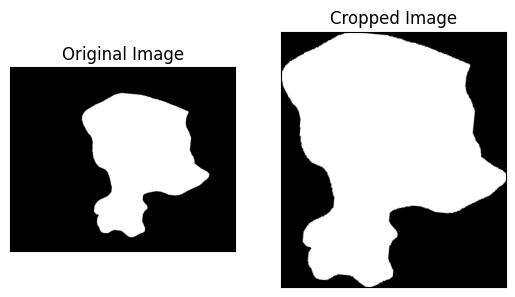

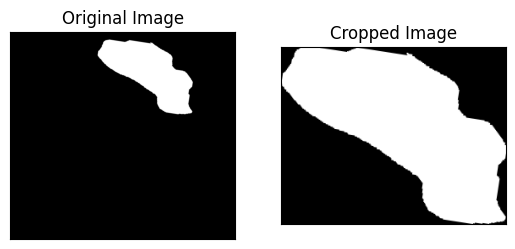

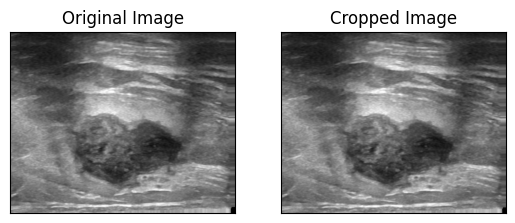

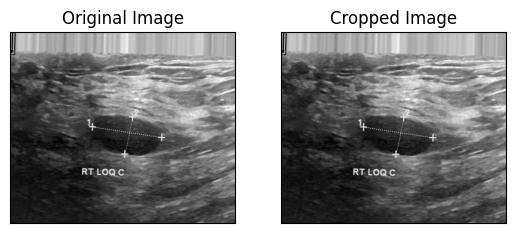

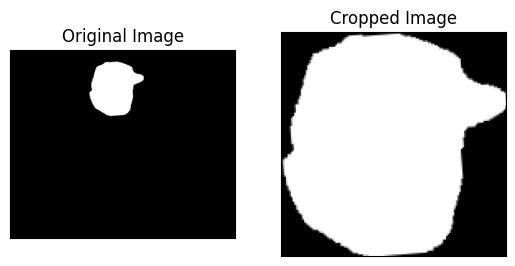

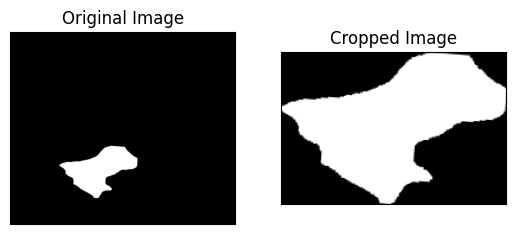

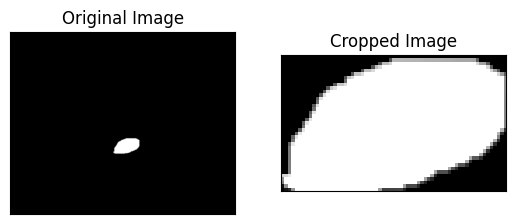

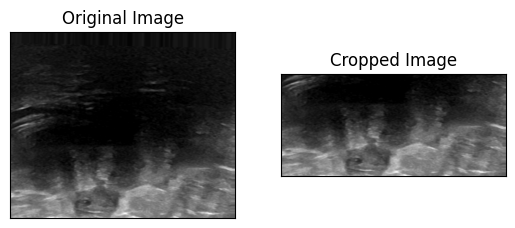

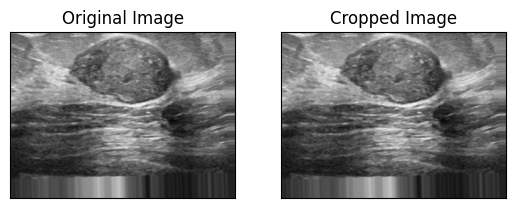

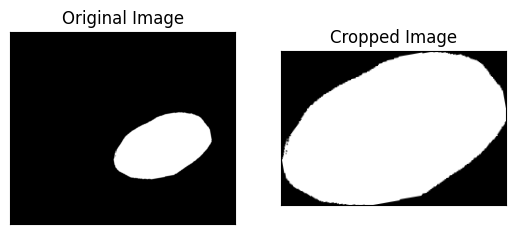

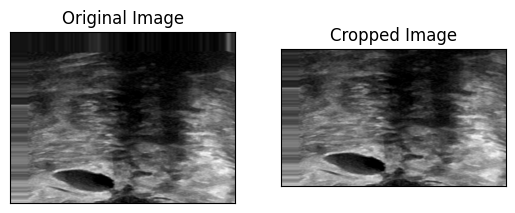

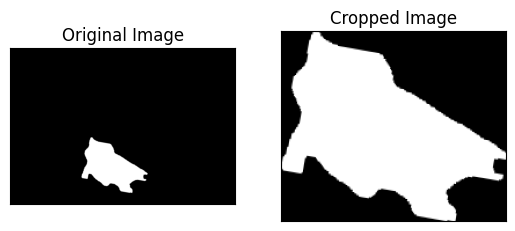

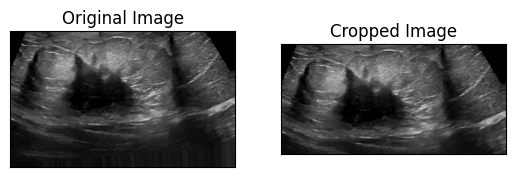

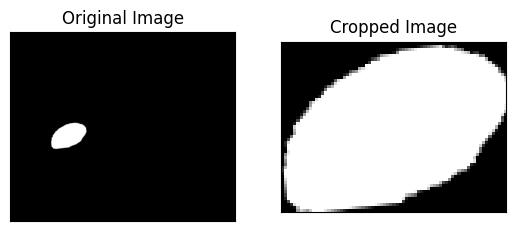

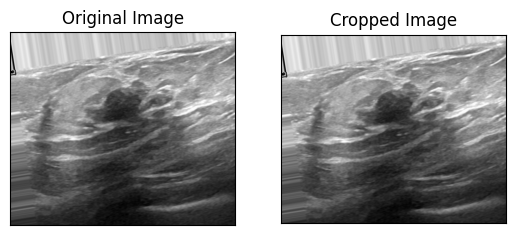

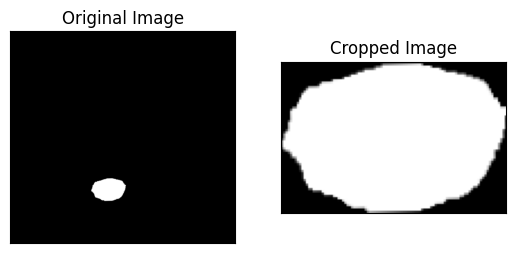

In [ ]:
plt.figure(figsize=(20, 20))
for i in range(16):
    random_class = random.randint(0, 1)
    folder_path = file_path + '/' + class_names[random_class]
    random_image_path = folder_path + '/' + (random.sample(os.listdir(folder_path), 1)[0])
    image = cv2.imread(random_image_path)
    ex_crop_img = crop_image_contour(image, True)

In [ ]:
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout
from tensorflow.keras.callbacks import TensorBoard, ModelCheckpoint, ReduceLROnPlateau

In [ ]:
NUM_CLASSES = 3
IMG_HEIGHT = 224
IMG_WIDTH = 224
BATCH_SIZE = 32

In [ ]:
IMG_SIZE=(224,224)
INPUT_SHAPE = IMG_SIZE + (3,)
model = tf.keras.models.Sequential()
model.add(tf.keras.layers.Rescaling(scale=1./255, input_shape=INPUT_SHAPE))
model.add(tf.keras.layers.Conv2D(filters=16, kernel_size=(3,3), padding='same', activation='relu'))
model.add(tf.keras.layers.MaxPooling2D(pool_size=(2,2)))
model.add(tf.keras.layers.Conv2D(filters=32, kernel_size=(3,3), padding='same', activation='relu'))
model.add(tf.keras.layers.MaxPooling2D(pool_size=(2,2)))
model.add(tf.keras.layers.Conv2D(filters=64, kernel_size=(3,3), padding='same', activation='relu'))
model.add(tf.keras.layers.MaxPooling2D(pool_size=(2,2)))
model.add(tf.keras.layers.Conv2D(filters=128, kernel_size=(3,3), padding='same', activation='relu'))
model.add(tf.keras.layers.MaxPooling2D(pool_size=(2,2)))
model.add(tf.keras.layers.Conv2D(filters=256, kernel_size=(3,3), padding='same', activation='relu'))
model.add(tf.keras.layers.MaxPooling2D(pool_size=(2,2)))
model.add(tf.keras.layers.Conv2D(filters=512, kernel_size=(3,3), padding='same', activation='relu'))
model.add(tf.keras.layers.MaxPooling2D(pool_size=(2,2)))
model.add(tf.keras.layers.Conv2D(filters=1024, kernel_size=(3,3), padding='same', activation='relu'))
model.add(tf.keras.layers.MaxPooling2D(pool_size=(2,2)))
model.add(tf.keras.layers.Dropout(0.20))
model.add(tf.keras.layers.Flatten())
model.add(tf.keras.layers.Dense(128, activation='relu'))
model.add(tf.keras.layers.Dense(3, activation = 'softmax'))

In [ ]:
# Set the hyperparameters
learning_rate = 0.0001
num_epochs = 30
early_stop_patience = 10

In [ ]:
optimizer = Adam(learning_rate=learning_rate)

In [ ]:
# define callbacks
checkpoint = ModelCheckpoint('/content/drive/MyDrive/PROJECTS/breast cancer detection/models/model-{epoch:02d}-{val_accuracy:.4f}.hdf5',
                              monitor='val_accuracy',
                              verbose=1,
                              save_best_only=True,
                              mode='max')

early_stop = EarlyStopping(monitor='val_accuracy',
                           patience=10,
                           mode='max',
                           verbose=1,
                           restore_best_weights=True)

reduce_lr = ReduceLROnPlateau(monitor='val_loss',
                              factor=0.2,
                              patience=5,
                              min_lr=0.00001,
                              verbose=1)

In [ ]:
model.compile(optimizer=optimizer, loss='sparse_categorical_crossentropy', metrics=['accuracy'])

In [ ]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 rescaling (Rescaling)       (None, 224, 224, 3)       0         
                                                                 
 conv2d (Conv2D)             (None, 224, 224, 16)      448       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 112, 112, 16)     0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 112, 112, 32)      4640      
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 56, 56, 32)       0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (None, 56, 56, 64)        1

In [ ]:
batch_size=32
epochs=20

In [ ]:
history = model.fit(X_train,epochs=num_epochs, validation_data=X_validation,verbose=1,callbacks=[checkpoint, early_stop, reduce_lr])

Epoch 1/30
311/311 [==============================] - ETA: 0s - loss: 0.7413 - accuracy: 0.6573
Epoch 1: val_accuracy improved from -inf to 0.69481, saving model to /content/drive/MyDrive/PROJECTS/breast cancer detection/models/model-01-0.6948.hdf5
311/311 [==============================] - 1039s 3s/step - loss: 0.7413 - accuracy: 0.6573 - val_loss: 0.6725 - val_accuracy: 0.6948 - lr: 1.0000e-04
Epoch 2/30
311/311 [==============================] - ETA: 0s - loss: 0.5734 - accuracy: 0.7461
Epoch 2: val_accuracy improved from 0.69481 to 0.76920, saving model to /content/drive/MyDrive/PROJECTS/breast cancer detection/models/model-02-0.7692.hdf5
311/311 [==============================] - 81s 257ms/step - loss: 0.5734 - accuracy: 0.7461 - val_loss: 0.5126 - val_accuracy: 0.7692 - lr: 1.0000e-04
Epoch 3/30
311/311 [==============================] - ETA: 0s - loss: 0.4664 - accuracy: 0.8049
Epoch 3: val_accuracy improved from 0.76920 to 0.79976, saving model to /content/drive/MyDrive/PROJECT

In [ ]:
model_evaluate = model.evaluate(X_validation)
print("Accuracy: %", "{:.2f}".format(model_evaluate[1]*100))
print("Loss: %", "{:.2f}".format(model_evaluate[0]*100))

78/78 [==============================] - 14s 166ms/step - loss: 0.4789 - accuracy: 0.9152
Accuracy: % 91.52
Loss: % 47.89


[]

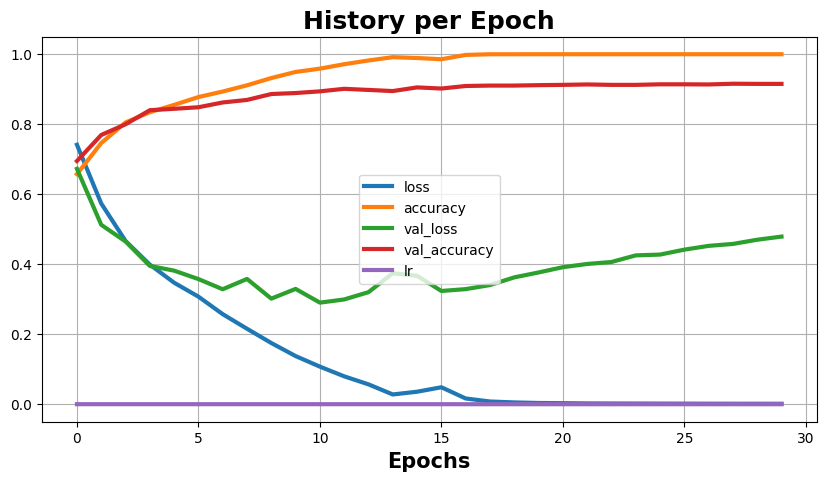

In [ ]:
df = pd.DataFrame(history.history)
ax = df.plot(figsize=(10,5), lw=3, grid='on')
ax.set_title('History per Epoch', fontsize=18, fontweight='bold')
ax.set_xlabel('Epochs', fontsize=15, fontweight='bold')
ax.plot()

1/1 [==============================] - 0s 30ms/step


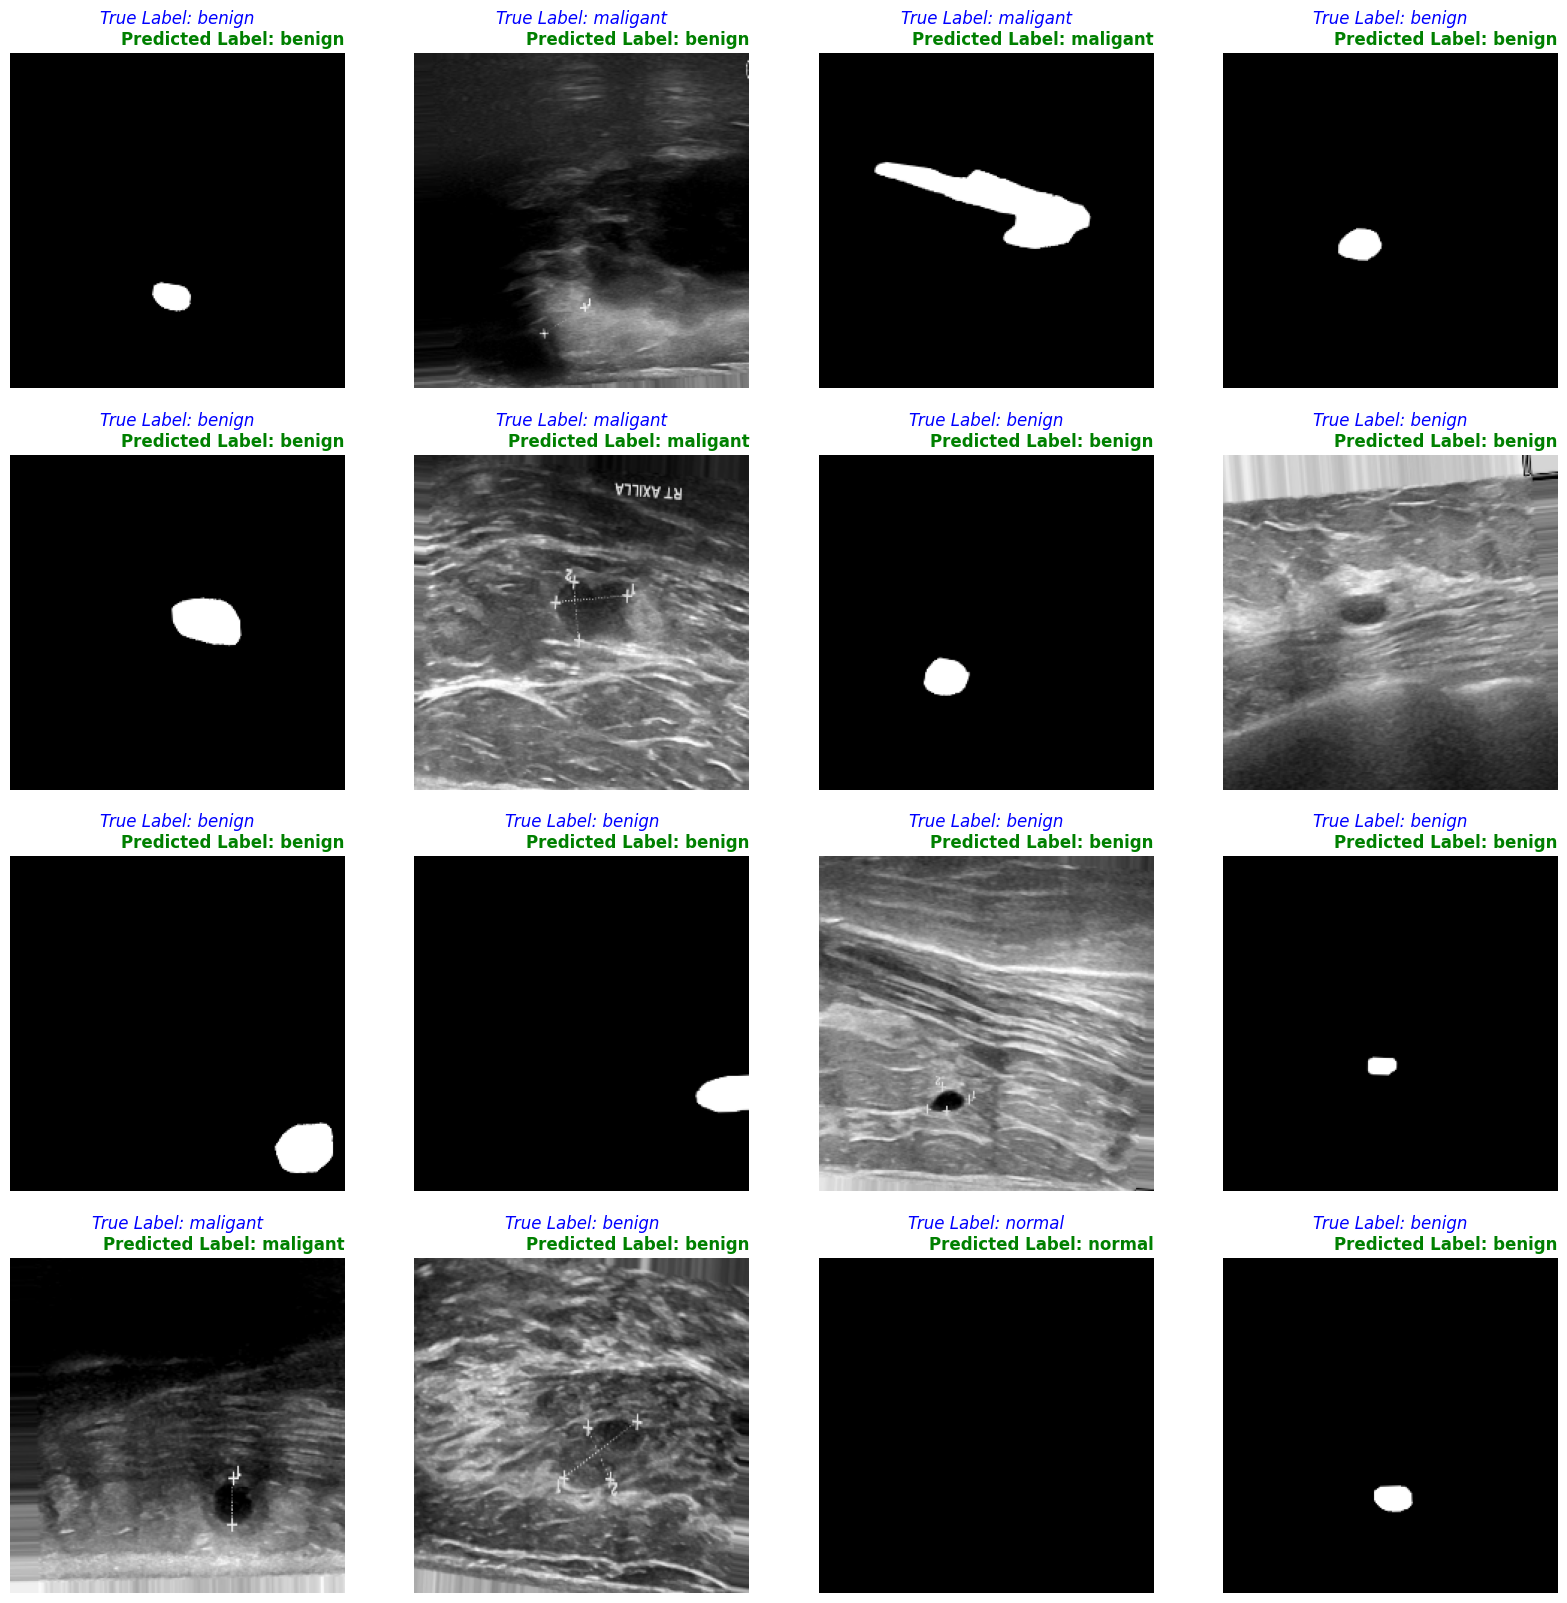

In [ ]:
plt.figure(figsize=(20, 20))
model = load_model('/content/drive/MyDrive/PROJECTS/breast cancer detection/models/model-28-0.9156.hdf5')
for image, label in X_validation.take(1):
    for i in range(16):
        ax = plt.subplot(4, 4, i+1)
        img = image[i].numpy().astype("uint8")
        img = tf.expand_dims(img, axis=0)
        predicted_class = np.argmax(model.predict(img))
        plt.axis('off')
        plt.title("True Label: " + class_names[label[i]]+'\n', fontsize=12, style='italic', color='blue', loc='center')
        plt.title("Predicted Label: " + class_names[predicted_class], fontsize=12, fontweight='bold', color='green', loc='right')
        plt.imshow(image[i].numpy().astype("uint8"))

In [ ]:
!pip install gradio

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 17.3/17.3 MB 48.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 140.5/140.5 kB 15.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 286.2/286.2 kB 23.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 50.5/50.5 kB 3.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.0/1.0 MB 51.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 45.7/45.7 kB 4.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 129.7/129.7 kB 14.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 224.5/224.5 kB 21.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 57.8/57.8 kB 6.6 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 75.3/75.3 kB 7.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 57.0/57.0 

In [ ]:
import gradio as gr
import cv2
import imutils
import matplotlib.pyplot as plt
from tensorflow.keras.models import Model,load_model
import numpy as np
import pathlib

file_path = '/content/drive/MyDrive/PROJECTS/breast cancer detection/augmented-images'
data_dir = pathlib.Path(file_path)
class_names = np.array(sorted([item.name for item in data_dir.glob('*')]))


model = load_model('/content/drive/MyDrive/PROJECTS/breast cancer detection/models/model-28-0.9156.hdf5')

# Define a function to run the model on user input and return predictions
def predict_breast_cancer(img_array):
    img_array = cv2.resize(img_array, (224,224))
    img_array = np.array(img_array).reshape(1,224,224, 3)
    prediction = model.predict([img_array])
    class_idx = np.argmax(prediction)
    class_name = class_names[class_idx]
    confidence_score = prediction[0][class_idx] * 100 # multiplying by 100 to get percentage
    result = f"{class_name} ({confidence_score:.2f}%)"
    return result

inputs = gr.inputs.Image(label="Input Image")
outputs = gr.outputs.Textbox(label="Prediction")


title = "Breast Cancer Detection"
description = "Upload an image and the model will predict whether it contains a normal,malignant,benign"

gr.Interface(fn=predict_breast_cancer, inputs=inputs, outputs=outputs, title=title, description=description).launch(debug=True,share=True)


/usr/local/lib/python3.9/dist-packages/gradio/inputs.py:257: UserWarning: Usage of gradio.inputs is deprecated, and will not be supported in the future, please import your component from gradio.components
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/gradio/deprecation.py:40: UserWarning: `optional` parameter is deprecated, and it has no effect
  warnings.warn(value)
/usr/local/lib/python3.9/dist-packages/gradio/outputs.py:22: UserWarning: Usage of gradio.outputs is deprecated, and will not be supported in the future, please import your components from gradio.components
  warnings.warn(


Colab notebook detected. This cell will run indefinitely so that you can see errors and logs. To turn off, set debug=False in launch().
Running on public URL: https://e3749987351ae0e2dd.gradio.live

This share link expires in 72 hours. For free permanent hosting and GPU upgrades (NEW!), check out Spaces: https://huggingface.co/spaces


1/1 [==============================] - 0s 47ms/step
Keyboard interruption in main thread... closing server.
Killing tunnel 127.0.0.1:7860 <> https://e3749987351ae0e2dd.gradio.live
